# Training a CNN on biotic/non-biotic test set

Just doing biotic/non biotic, using the pre-defined training set.
We can choose if we use the full or small training set.

TODO:
- Load the model back in and do hard negative mining on the training set
- We should be doing hyperopt here
- Compare directly to a forest

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import os
import numpy as np
import collections
import scipy.io

from lasagne import layers
from lasagne.nonlinearities import softmax
from lasagne.updates import adam
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import TrainSplit
from nolearn.lasagne import objective
from lasagne.layers import get_all_params

# import hyperopt
# from hyperopt import hp, fmin, tpe

from time import time

from sklearn import metrics
from sklearn.metrics import roc_curve, auc

Using gpu device 0: GeForce GTX 770


## Loading in the training/test data

This split was done in 'Biotic slice extraction'

In [2]:
datapath = '/home/michael/projects/engaged_hackathon_data/detection/train_test_patches/'
data_small = scipy.io.loadmat(datapath + 'small.mat')
data_big = scipy.io.loadmat(datapath + 'full.mat')

datasetsize = 'full'

train, test = {}, {}
train['X'] = data_big['X_train']
train['y'] = data_big['y_train'].ravel()
test['X'] = data_big['X_test']
test['y'] = data_big['y_test'].ravel()

print "Training data"
for key, val in train.iteritems():
    print key, val.shape
    
print "Testing data"
for key, val in test.iteritems():
    print key, val.shape

Training data
y (50836,)
X (50836, 1, 75, 19)
Testing data
y (18286,)
X (18286, 1, 75, 19)


## Setting up and training the CNN, using NoLearn (& Lasagne)

In [3]:
# Xmnist
layers0 = [
    # layer dealing with the input data
    (layers.InputLayer, {'shape': (None, train['X'].shape[1], train['X'].shape[2], train['X'].shape[3])}),

    # first stage of our convolutional layers
    (layers.Conv2DLayer, {'num_filters': 96, 'filter_size': 5}),
#     (layers.Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
#     (layers.Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
#     (layers.Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (layers.Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (layers.MaxPool2DLayer, {'pool_size': 2}),

    # second stage of our convolutional layers
    (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (layers.MaxPool2DLayer, {'pool_size': 2}),

    # two dense layers with dropout
    (layers.DenseLayer, {'num_units': 64}),
    (layers.DropoutLayer, {}),
    (layers.DenseLayer, {'num_units': 64}),

    # the output layer
    (layers.DenseLayer, {'num_units': 2 , 'nonlinearity': softmax}),
]

def regularization_objective(layers, lambda1=0., lambda2=0., *args, **kwargs):
    # default loss
    losses = objective(layers, *args, **kwargs)
    # get the layers' weights, but only those that should be regularized
    # (i.e. not the biases)
    weights = get_all_params(layers[-1], regularizable=True)
    # sum of absolute weights for L1
    sum_abs_weights = sum([abs(w).sum() for w in weights])
    # sum of squared weights for L2
    sum_squared_weights = sum([(w ** 2).sum() for w in weights])
    # add weights to regular loss
    losses += lambda1 * sum_abs_weights + lambda2 * sum_squared_weights
    return losses


net0 = NeuralNet(
    layers=layers0,
    max_epochs=10,

    update=adam,
    update_learning_rate=0.0002,

    objective=regularization_objective,
    objective_lambda2=0.0025,
    regression=False,
    train_split=TrainSplit(eval_size=0.25),
    verbose=1,
)

# Train the network
net0.fit(train['X'], train['y']);

# Neural Network with 618658 learnable parameters

## Layer information

  #  name        size
---  ----------  --------
  0  input0      1x75x19
  1  conv2d1     96x71x15
  2  conv2d2     96x69x13
  3  maxpool2d3  96x35x7
  4  conv2d4     128x33x5
  5  conv2d5     128x31x3
  6  conv2d6     128x29x1
  7  maxpool2d7  128x15x1
  8  dense8      64
  9  dropout9    64
 10  dense10     64
 11  dense11     2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -------
      1       1.22662       0.77598      1.58074      0.81154  100.98s
      2       0.70078       0.61957      1.13108      0.82068  101.02s
      3       0.59823       0.55440      1.07905      0.82331  101.86s
      4       0.54997       0.51972      1.05820      0.82638  101.05s
      5       0.52058       0.49859      1.04410      0.83115  100.66s
      6       0.50152       0.47823      1.04870      0.83373  99.90s
      7       0.48624       0.

## Classification accuracy on the test set

In [4]:
#threshold = threshold
pred_y = net0.predict_proba(test['X'])[:, 1]

test_accuracy = metrics.accuracy_score(test['y'], pred_y>0.5)

print "Test accuracy is %f" % test_accuracy

Test accuracy is 0.850213


## ROC Curve

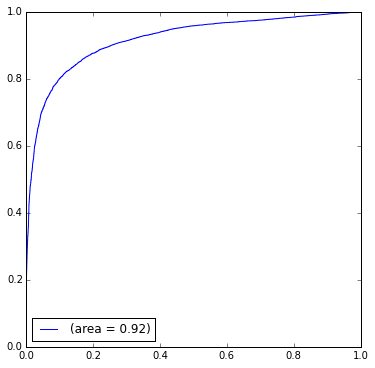

In [5]:
from sklearn.metrics import roc_curve, auc

# plotting this line
plt.figure(figsize=(6, 6))
fpr, tpr, _ = roc_curve(test['y'], pred_y.ravel())

roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr , label='(area = %0.2f)' % (roc_auc))
plt.legend(loc='best')

In [6]:
# Save the model to disk...
import cPickle as pickle

savedir = '/home/michael/projects/engaged_hackathon_data/detection/models/'
with open(savedir + 'cnn_' + datasetsize + '.pkl', 'w') as f:
    pickle.dump(net0, f, -1)


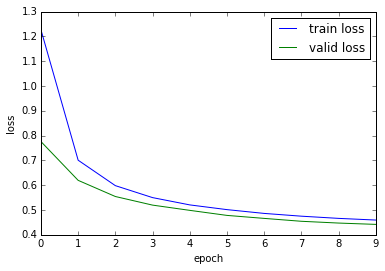

In [7]:
# Introspection into the model

from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion
plot_loss(net0)

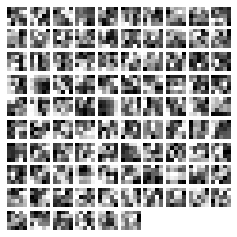

In [8]:
plot_conv_weights(net0.layers_[1], figsize=(4, 4))

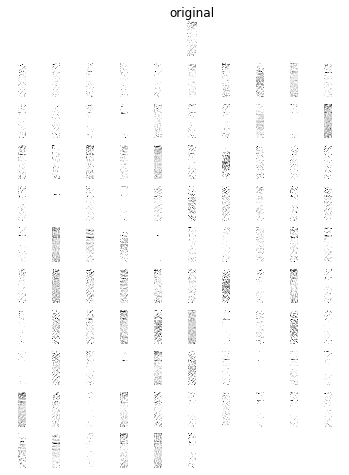

In [9]:
plot_conv_activity(net0.layers_[1], train['X'][0:1])

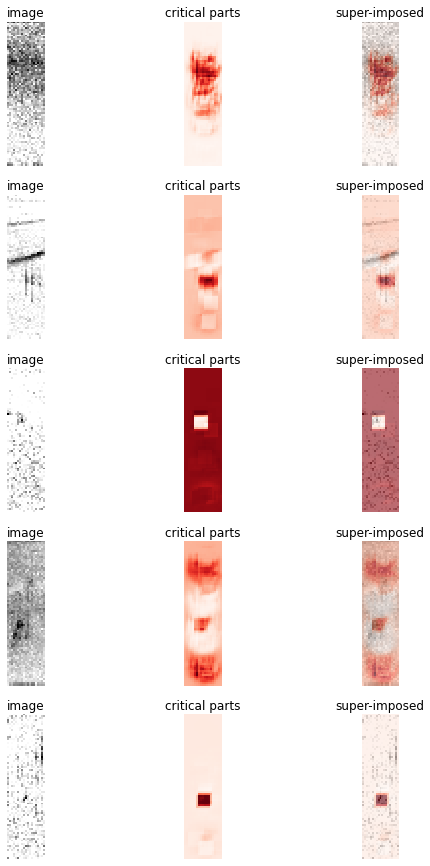

In [10]:
plot_occlusion(net0, train['X'][10:15], train['y'][10:15])

## Plotting the distribution of predictions for each class

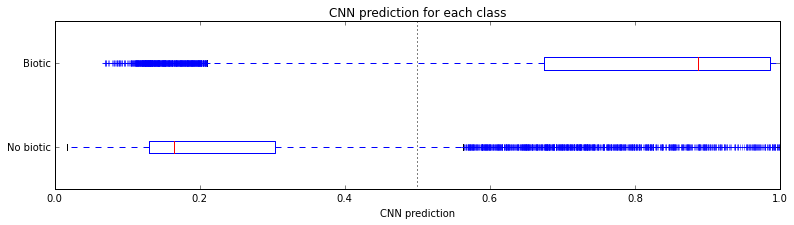

In [13]:
plt.figure(figsize=(13, 3))
plt.boxplot([pred_y[test['y'] == 0], pred_y[test['y'] == 1]], 0, 'b+', 0)
plt.xlim(0, 1)
plt.plot([0.5, 0.5], [0, 3], 'k:')
plt.xlabel('CNN prediction')
plt.gca().set_yticklabels(['No biotic', 'Biotic'])
plt.title('CNN prediction for each class')